# RNN Playground: Configurable Time Series Data Pipeline

# Supportive functions 

In [121]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [174]:
# Configurable parameters
CONFIG = {
    "total_points": 1000,
    "train_split": 0.8,
    "time_steps": 20,  # Used for windowing
    "batch_size": 32,
    "seq_to_seq": not True,  # If False, does seq-to-vector
    "noise_std": 0.1,
    "seed": 42,
    "stride": 1,  # Window shift
    "n_features": 2,  # Number of features
}

np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])

## Generate Synthetic Time Series Data

In [175]:
def generate_time_series(total_points, noise_std=0.1, n_features=1):
    t = np.linspace(0, 50, total_points)
    features = []
    for i in range(n_features):
        phase = i * np.pi / 4
        freq = 1 + 0.2 * i
        y = np.sin(freq * t + phase) + np.random.normal(0, noise_std, size=total_points)
        features.append(y)
    y = np.stack(features, axis=-1)  # shape: (total_points, n_features)
    return t, y

In [176]:
def plot_time_series(t, y, title="Synthetic Time Series Data"):
    plt.figure(figsize=(12, 4))
    for i in range(y.shape[1]):
        plt.plot(t, y[:, i], label=f"Feature {i}")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [177]:
t, y = generate_time_series(CONFIG["total_points"], CONFIG["noise_std"], CONFIG["n_features"])

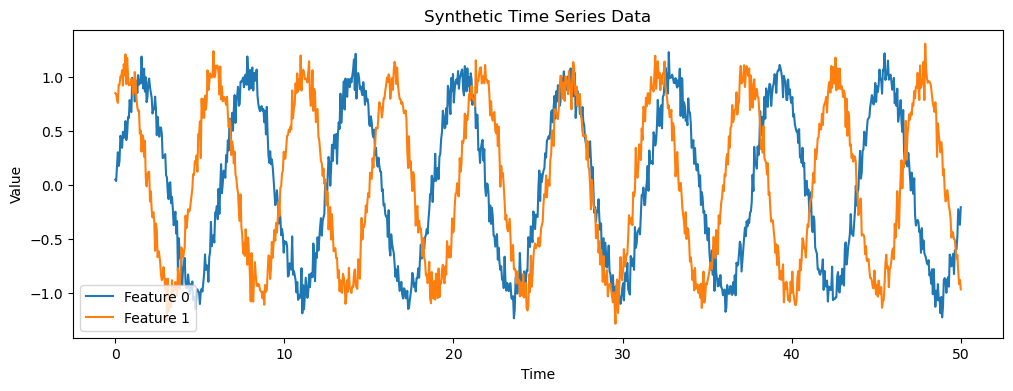

In [178]:
plot_time_series(t, y)

## Data Pipeline (tf.data) for RNN 

In [179]:
def make_dataset(series, time_steps, batch_size, seq_to_seq=True, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(series)

    ds = ds.window(time_steps + 1, shift=CONFIG.get("stride", 1), drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(time_steps + 1))

    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=CONFIG["seed"])

    if seq_to_seq:
        ds = ds.map(lambda window: (window[:-1], window[1:]))
    else:
        ds = ds.map(lambda window: (window[:-1], window[-1:]))  # Make target shape (1, n_features)

    if not seq_to_seq:
        ds = ds.map(lambda x, y: (x,  tf.squeeze(y, axis=0)))  
    else:
        ds = ds.map(lambda x, y: (x,  y))  

    ds = ds.batch(batch_size).prefetch(1)

    return ds

In [180]:
full_ds = make_dataset(
    y,
    time_steps=CONFIG["time_steps"],
    batch_size=CONFIG["batch_size"],
    seq_to_seq=CONFIG["seq_to_seq"],
    shuffle=False,
)

In [181]:
# Calculate number of windows for splitting
total_windows = CONFIG["total_points"] - CONFIG["time_steps"] - (0 if CONFIG["seq_to_seq"] else 1) + 1
train_windows = int(total_windows * CONFIG["train_split"])
test_windows = total_windows - train_windows

train_ds = full_ds.take(train_windows // CONFIG["batch_size"])
test_ds = full_ds.skip(train_windows // CONFIG["batch_size"])

## Debug

In [182]:
y.shape

(1000, 2)

In [183]:
for i in train_ds.take(1):
    print(i[0].shape, i[1].shape)

(32, 20, 2) (32, 2)


# <font color=red> Test RNN Models </font>

## Model 1

In [186]:
_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(CONFIG["time_steps"], CONFIG["n_features"])),  # None for time_steps, n_features for features
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(CONFIG["n_features"]),  # Output shape (time_steps, n_features)
    # tf.keras.layers.Reshape([CONFIG["time_steps"], CONFIG["n_features"]])  # Reshape to (19, n_features)
])

In [187]:
_model.compile(optimizer='adam', loss='mse')
_model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,546 (17.76 KB)

 Trainable params: 4,546 (17.76 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
_out = train_ds.take(1).as_numpy_iterator().next()  

In [189]:
_model.output_shape, _out[1].shape

((None, 2), (32, 2))

In [190]:
_model.input_shape, _out[0].shape

((None, 20, 2), (32, 20, 2))

In [191]:
history1 = _model.fit(train_ds, epochs=5, verbose=1)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6015
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6015
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3023
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3023
Epoch 3/5
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0677

/opt/conda/envs/py39_tensorflow/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1403
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1403
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0884
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0884
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0738
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0738
